In [85]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [86]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [87]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])





In [88]:
train_dataset=torchvision.datasets.DatasetFolder(
    "Processed/train/",
    loader=load_file,extensions=".npy",transform=train_transforms)
val_dataset=torchvision.datasets.DatasetFolder(
    "Processed/val/",
    loader=load_file,extensions=".npy",transform=val_transforms)



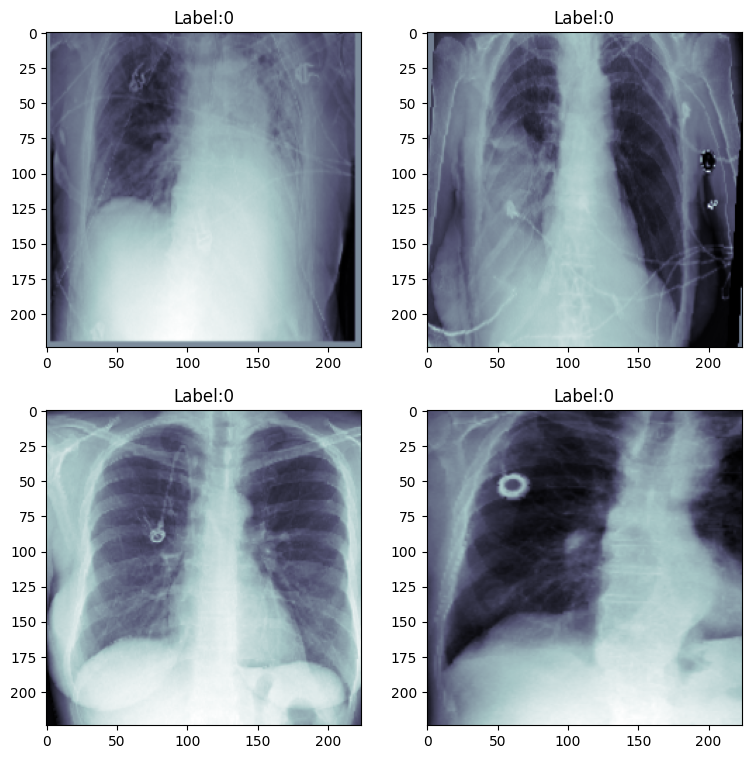

In [89]:
fig,axis=plt.subplots(2,2,figsize=(9,9))
for i in range(2):
    for j in range(2):
        random_index=np.random.randint(0,20000)
        x_ray,label=train_dataset[random_index]
        axis[i][j].imshow(x_ray[0],cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [90]:
print(f"train_dataset has {len(train_dataset)} images")
print(f"val_dataset has {len(val_dataset)} images")

train_dataset has 24000 images
val_dataset has 2684 images


In [91]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64,num_workers=0,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size=64,num_workers=0,shuffle=False)

In [92]:
torchvision.models.resnet18()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [93]:
np.unique(train_dataset.targets,return_counts=True)

(array([0, 1]), array([18593,  5407]))

In [94]:
from torchmetrics.classification import Accuracy,AUROC
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model=torchvision.models.resnet18()
        self.model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc=torch.nn.Linear(in_features=512, out_features=1, bias=True)


        self.optimizer=torch.optim.Adam(self.model.parameters(),lr=1e-4)
        self.loss_fn=torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

        self.train_acc=Accuracy(task="binary")
        self.val_acc=Accuracy(task="binary")
        self.val_auc =AUROC(task="binary")

    def forward(self, data):
        pred=self.model(data)
        return pred
    

    def training_step(self,batch,batch_idx):
        x_ray,label=batch
        label=label.float()
        pred=self(x_ray).squeeze(1)
        loss=self.loss_fn(pred,label)

        probs=torch.sigmoid(pred)
        acc=self.train_acc(probs,label.int())

        self.log("Train Loss",loss,prog_bar=True,on_step=False,on_epoch=True)
        self.log("Step Train ACC",acc,prog_bar=True,on_step=False,on_epoch=True)
        
        return loss
    
    
    def on_training_epoch_end(self):
        self.log("Train ACC",self.train_acc.compute())
        

    def validation_step(self,batch,batch_idx):
        x_ray,label=batch
        label=label.float()
        pred=self(x_ray).squeeze(1)        
        loss=self.loss_fn(pred,label)

        probs=torch.sigmoid(pred)

        acc=self.val_acc(probs,label.int())
        self.log("Val Loss",loss,prog_bar=True,on_step=False, on_epoch=True)
        self.log("val_acc",  acc,   prog_bar=True, on_step=False, on_epoch=True)
        self.val_auc.update(probs, label.int())

        
        

    def on_validation_epoch_end(self):
        auroc = self.val_auc.compute()
        self.log("val_auroc", auroc, prog_bar=True)
        self.val_auc.reset()



    def configure_optimizers(self):
        return [self.optimizer]


In [95]:
model=PneumoniaModel()

In [96]:
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
checkpoint_callback_acc=ModelCheckpoint(
    monitor="val_acc",
    save_top_k=1,
    mode="max",
    filename="best-acc-{epoch:02d}-{val_acc:.4f}-{val_auroc:.4f}"
)
early_stop = EarlyStopping(monitor="val_auroc", mode="max", patience=5)
checkpoint_callback_auroc=ModelCheckpoint(
    monitor="val_auroc",
    save_top_k=1,
    mode="max",
    filename="best-auroc-{epoch:02d}-{val_acc:.4f}-{val_auroc:.4f}"
)

In [97]:

trainer=pl.Trainer(accelerator="gpu",devices=1,
        logger=TensorBoardLogger(save_dir="./logs"),log_every_n_steps=1,max_epochs=35,
        callbacks=[checkpoint_callback_acc,checkpoint_callback_auroc,early_stop])

       
        

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [98]:
import numpy as np

train_labels = [y for _, y in train_dataset]
val_labels   = [y for _, y in val_dataset]

print("Train positives:", np.sum(train_labels), 
      "negatives:", len(train_labels) - np.sum(train_labels))
print("Val positives:", np.sum(val_labels), 
      "negatives:", len(val_labels) - np.sum(val_labels))


Train positives: 5407 negatives: 18593
Val positives: 605 negatives: 2079


In [99]:
print(f"Val_loader has {len(val_loader)} images")
print(f"train_loader has {len(train_loader)} images")

Val_loader has 42 images
train_loader has 375 images


In [100]:
trainer.fit(model,train_loader,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
4 | val_auc   | BinaryAUROC       | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\venvs\cuda_env312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
c:\venvs\cuda_env312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
c:\venvs\cuda_env312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [101]:
print("Best ACC ckpt:", checkpoint_callback_acc.best_model_path)
print("Best AUROC ckpt:", checkpoint_callback_auroc.best_model_path)

Best ACC ckpt: ./logs\lightning_logs\version_5\checkpoints\best-acc-epoch=23-val_acc=0.8294-val_auroc=0.8840.ckpt
Best AUROC ckpt: ./logs\lightning_logs\version_5\checkpoints\best-auroc-epoch=25-val_acc=0.8171-val_auroc=0.8936.ckpt


In [107]:
import os
print(os.getcwd())


c:\Users\milos\Projects\rsna-pneumonia-detection-challenge


In [109]:
import glob
print(glob.glob("**/*.ckpt", recursive=True))


['logs\\lightning_logs\\version_3\\checkpoints\\epoch=0-step=375.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=1-step=750.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=2-step=1125.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=28-step=10875.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=29-step=11250.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=30-step=11625.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=31-step=12000.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=32-step=12375.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=33-step=12750.ckpt', 'logs\\lightning_logs\\version_3\\checkpoints\\epoch=34-step=13125.ckpt', 'logs\\lightning_logs\\version_4\\checkpoints\\best-acc-epoch=02-val_acc=0.0000-val_auroc=0.0000.ckpt', 'logs\\lightning_logs\\version_4\\checkpoints\\best-auroc-epoch=01-val_acc=0.0000-val_auroc=0.0000.ckpt', 'logs\\lightning_logs\\version_5\\checkpoints\\best-acc-e

In [ ]:
import os

ckpt_path = r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\logs\lightning_logs\version_5\checkpoints\best-auroc-epoch=25-val_acc=0.8171-val_auroc=0.8936.ckpt"

print("Exists?", os.path.exists(ckpt_path))
print("Dir listing:", os.listdir(os.path.dirname(ckpt_path)))


Exists? False
Dir listing: ['best-acc-epoch=23-val_acc=0.8294-val_auroc=0.8840.ckpt', 'best-auroc-epoch=25-val_acc=0.8171-val_auroc=0.8936.ckpt']


In [112]:
import os
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ckpt_path = r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\logs\lightning_logs\version_5\checkpoints\best-auroc-epoch=25-val_acc=0.8171-val_auroc=0.8936.ckpt"


model=PneumoniaModel.load_from_checkpoint(ckpt_path)
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [113]:
preds=[]
labels=[]

with torch.no_grad():
    for data,label in tqdm(val_dataset):
        data=data.to(device).float().unsqueeze(0)
        pred=torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds=torch.tensor(preds)
labels=torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [115]:
import torch
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, ConfusionMatrix
acc=Accuracy(task="binary")(preds,labels)
precision=Precision(task="binary")(preds,labels)
recall=Recall(task="binary")(preds,labels)
cm=ConfusionMatrix(task="binary", num_classes=2)(preds,labels)
auroc=AUROC(task="binary")(preds,labels)

print(f"Val Accuracy:  {acc:.4f}")
print(f"Val Precision: {precision:.4f}")
print(f"Val Recall:    {recall:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"AUROC :  {auroc:.4f}")

Val Accuracy:  0.8171
Val Precision: 0.5672
Val Recall:    0.7950
Confusion Matrix:
tensor([[1712,  367],
        [ 124,  481]])
AUROC :  0.8936
